In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load
from keras.models import load_model
import seaborn as sb
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

# comment the below line if you not using jupyter notebook
%matplotlib inline

In [47]:
print("Started reading the data for training...")
df_ = pd.read_csv('train.csv')
df = df_.copy()
# df_training = df.iloc[:,:].copy()
print("Finished reading the data")

Started reading the data for training...
Finished reading the data


In [48]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['color_type'])
df['color_type'] = le.transform(df['color_type'])

In [69]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['breed_category']])
y = enc.transform(df[['breed_category']]).toarray()

In [72]:
x = df[['color_type', 'length(m)', 'height(cm)', 'X1', 'X2']].values

In [74]:
def scaleData(x, y):
    sc_x = StandardScaler()
    sc_y = StandardScaler()

    sc_x.fit(x)
    sc_y.fit(y)
    
    return sc_x, sc_y

In [75]:
sc_x, sc_y = scaleData(x,y)

In [79]:
x_scaled = sc_x.transform(x)

In [84]:
x_train = x_scaled[:15000,:]
y_train = y[:15000,:]
x_val = x_scaled[15000:,:]
y_val = y[15000:,:]

In [113]:
model = Sequential()
Kreg = None

model.add(Dense(128, activation = 'relu', input_shape = (x_train.shape[1],),
                kernel_initializer = glorot_uniform(seed = 1), kernel_regularizer = Kreg))

model.add(Dense(128, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 2), kernel_regularizer = Kreg))

model.add(Dense(128, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 3), kernel_regularizer = Kreg))

model.add(Dense(3, activation = 'sigmoid',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg))

In [114]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total params: 34,179
Trainable params: 34,179
Non-trainable params: 0
_________________________________________________________________


In [115]:
adam = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

es = EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('model1.h5', monitor='categorical_accuracy', mode='max', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_val,y_val),
                    verbose = 1, callbacks = callbacks)

Epoch 1/100
467/469 [============================>.] - ETA: 0s - loss: 0.8313 - categorical_accuracy: 0.5048
Epoch 00001: categorical_accuracy improved from -inf to 0.50460, saving model to model1.h5
469/469 [==============================] - 1s 3ms/step - loss: 0.8311 - categorical_accuracy: 0.5046 - val_loss: 0.8228 - val_categorical_accuracy: 0.4984
Epoch 2/100
460/469 [============================>.] - ETA: 0s - loss: 0.8085 - categorical_accuracy: 0.5102
Epoch 00002: categorical_accuracy improved from 0.50460 to 0.51053, saving model to model1.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.8086 - categorical_accuracy: 0.5105 - val_loss: 0.8145 - val_categorical_accuracy: 0.5081
Epoch 3/100
461/469 [============================>.] - ETA: 0s - loss: 0.8010 - categorical_accuracy: 0.5113
Epoch 00003: categorical_accuracy improved from 0.51053 to 0.51213, saving model to model1.h5
469/469 [==============================] - 1s 2ms/step - loss: 0.8008 - categorical_

Epoch 25/100
453/469 [===========================>..] - ETA: 0s - loss: 0.7647 - categorical_accuracy: 0.5488
Epoch 00025: categorical_accuracy did not improve from 0.55167
469/469 [==============================] - 1s 2ms/step - loss: 0.7643 - categorical_accuracy: 0.5485 - val_loss: 0.7894 - val_categorical_accuracy: 0.5316
Epoch 26/100
458/469 [============================>.] - ETA: 0s - loss: 0.7630 - categorical_accuracy: 0.5522
Epoch 00026: categorical_accuracy did not improve from 0.55167
469/469 [==============================] - 1s 2ms/step - loss: 0.7632 - categorical_accuracy: 0.5511 - val_loss: 0.7934 - val_categorical_accuracy: 0.5224
Epoch 27/100
465/469 [============================>.] - ETA: 0s - loss: 0.7627 - categorical_accuracy: 0.5511
Epoch 00027: categorical_accuracy did not improve from 0.55167
469/469 [==============================] - 1s 3ms/step - loss: 0.7626 - categorical_accuracy: 0.5514 - val_loss: 0.7906 - val_categorical_accuracy: 0.5287
Epoch 28/100
451

Epoch 50/100
454/469 [============================>.] - ETA: 0s - loss: 0.7440 - categorical_accuracy: 0.5700
Epoch 00050: categorical_accuracy improved from 0.56720 to 0.56900, saving model to model1.h5
469/469 [==============================] - 1s 3ms/step - loss: 0.7444 - categorical_accuracy: 0.5690 - val_loss: 0.7919 - val_categorical_accuracy: 0.5329
Epoch 51/100
448/469 [===========================>..] - ETA: 0s - loss: 0.7412 - categorical_accuracy: 0.5663
Epoch 00051: categorical_accuracy did not improve from 0.56900
469/469 [==============================] - 1s 2ms/step - loss: 0.7428 - categorical_accuracy: 0.5662 - val_loss: 0.7997 - val_categorical_accuracy: 0.5318
Epoch 52/100
467/469 [============================>.] - ETA: 0s - loss: 0.7421 - categorical_accuracy: 0.5664
Epoch 00052: categorical_accuracy did not improve from 0.56900
469/469 [==============================] - 1s 2ms/step - loss: 0.7423 - categorical_accuracy: 0.5661 - val_loss: 0.7920 - val_categorical_ac

Epoch 74/100
444/469 [===========================>..] - ETA: 0s - loss: 0.7215 - categorical_accuracy: 0.5814
Epoch 00074: categorical_accuracy did not improve from 0.58080
469/469 [==============================] - 1s 2ms/step - loss: 0.7218 - categorical_accuracy: 0.5793 - val_loss: 0.8029 - val_categorical_accuracy: 0.5347
Epoch 75/100
457/469 [============================>.] - ETA: 0s - loss: 0.7186 - categorical_accuracy: 0.5799
Epoch 00075: categorical_accuracy did not improve from 0.58080
469/469 [==============================] - 1s 3ms/step - loss: 0.7189 - categorical_accuracy: 0.5797 - val_loss: 0.8055 - val_categorical_accuracy: 0.5308
Epoch 76/100
458/469 [============================>.] - ETA: 0s - loss: 0.7184 - categorical_accuracy: 0.5824
Epoch 00076: categorical_accuracy improved from 0.58080 to 0.58200, saving model to model1.h5
469/469 [==============================] - 1s 3ms/step - loss: 0.7187 - categorical_accuracy: 0.5820 - val_loss: 0.8371 - val_categorical_ac

Epoch 99/100
459/469 [============================>.] - ETA: 0s - loss: 0.7026 - categorical_accuracy: 0.5827
Epoch 00099: categorical_accuracy did not improve from 0.58673
469/469 [==============================] - 1s 3ms/step - loss: 0.7024 - categorical_accuracy: 0.5829 - val_loss: 0.8452 - val_categorical_accuracy: 0.5323
Epoch 100/100
454/469 [============================>.] - ETA: 0s - loss: 0.7032 - categorical_accuracy: 0.5838
Epoch 00100: categorical_accuracy did not improve from 0.58673
469/469 [==============================] - 1s 2ms/step - loss: 0.7033 - categorical_accuracy: 0.5847 - val_loss: 0.8369 - val_categorical_accuracy: 0.5313


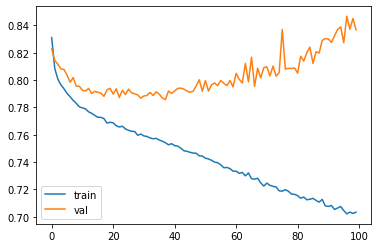

In [116]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

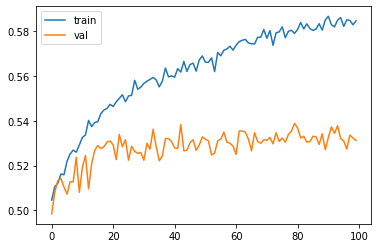

In [117]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [131]:
ymodel = model.predict(x_val)

In [132]:
ymodel = enc.inverse_transform(ymodel)
y_act = enc.inverse_transform(y_val)

In [133]:
from sklearn.metrics import f1_score

In [139]:
f1_score(ymodel[:,0],y_act[:,0],average='weighted')

0.5620327565832959